In [0]:
# Automatically reload external libraries that change
%reload_ext autoreload
%autoreload 2
# If a matplotlib plot command is issued, display the results in the notebook
%matplotlib inline

In [2]:
# Upload data
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [3]:
!tar xvzf track_shower_images.tar.gz

Images/
Images/Hits/
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_0_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_100_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_101_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_102_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_103_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_104_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_105_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_106_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_107_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_108_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_109_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_10_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_110_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_111_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_112_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_113_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_114_0.png
Images/Hits/Image_DUNEFD_MC11_CaloHitListW_115_0.png
Images/Hits/Image_DUNEFD_MC1

In [0]:
# Reduce to just 100 images
#!rm -f Images/Truth/Image*_[0-9][0-9][0-9]_0.png
#!rm -f Images/Hits/Image*_[0-9][0-9][0-9]_0.png
#!rm -f *.py

In [5]:
# Upload supporting python modules
from google.colab import files
files.upload()
from data import SegmentationBunch
from transforms import Rescale, ToTensor
from unet import UNet
import img_util as iu
import model_util as mu

Saving data.py to data.py
Saving img_util.py to img_util.py
Saving model_util.py to model_util.py
Saving transforms.py to transforms.py
Saving unet.py to unet.py


In [0]:
from data import open_image
img = open_image("Images/Truth/Image_DUNEFD_MC11_CaloHitListW_0_0.png")

In [7]:
img.size

(512, 208)

In [0]:
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.optim as opt
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [0]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
#bunch = SegmentationBunch("Images", "Hits", "Truth", batch_size=64, valid_pct = 0.2,
#    transform=transforms.Compose([Rescale((512, 208)), ToTensor()]))
bunch = SegmentationBunch("Images", "Hits", "Truth", batch_size=48, valid_pct = 0.2,
    transform=transforms.Compose([ToTensor(True)]))

In [0]:
void_code = 0

def accuracy(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
# Create the network, loss function and optimizer
n_classes = 3
model = UNet(1, n_classes = n_classes, n_filters = 16, y_range = (0, n_classes))
#print(model)
loss_fn = nn.CrossEntropyLoss(torch.tensor([0.,0.5,0.5]))
#optim = opt.Adam(model.parameters())
#optim = opt.Adam(model.parameters(), lr=2e-4)
#optim = opt.Adam(model.parameters(), lr=1e-4)
# Smoothest training, consistent with lr_finder
optim = opt.Adam(model.parameters(), lr=1.5e-4)

In [0]:
# Find learning rate
optim = opt.Adam(model.parameters(), lr=1e-7)
num_iter = 100
lr_lambda = lambda batch : get_running_factor(1e-7, 10, num_iter, batch)
lr_finder = mu.LRFinder(optim=optim, num_iter=num_iter)
lr_finder.find(model=model, input=bunch.train_dl, loss_fn=loss_fn)

Batch 0 has learning rate [1e-07]
Batch 1 has learning rate [1.2045035402587822e-07]
Batch 2 has learning rate [1.4508287784959398e-07]
Batch 3 has learning rate [1.7475284000076842e-07]
Batch 4 has learning rate [2.1049041445120208e-07]
Batch 5 has learning rate [2.5353644939701124e-07]
Batch 6 has learning rate [3.0538555088334166e-07]
Batch 7 has learning rate [3.678379771828635e-07]
Batch 8 has learning rate [4.430621457583883e-07]
Batch 9 has learning rate [5.336699231206313e-07]
Batch 10 has learning rate [6.428073117284325e-07]
Batch 11 has learning rate [7.742636826811276e-07]
Batch 12 has learning rate [9.326033468832207e-07]
Batch 13 has learning rate [1.1233240329780285e-06]
Batch 14 has learning rate [1.3530477745798083e-06]
Batch 15 has learning rate [1.6297508346206458e-06]
Batch 16 has learning rate [1.963040650040273e-06]
Batch 0 has learning rate [2.3644894126454104e-06]
Batch 1 has learning rate [2.8480358684358054e-06]
Batch 2 has learning rate [3.430469286314923e-06

In [0]:
learning_rates = lr_finder.get_learning_rates()
train_loss_epochs = lr_finder.get_losses()

In [0]:
def plot_lr(x, y, name, labels=("lr", "Loss")):
    fig, ax = plt.subplots()
    ax.set_title('Learning Rate Finder')
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.plot(x, y, c='darkred')
    iu.save_figure(fig, name)

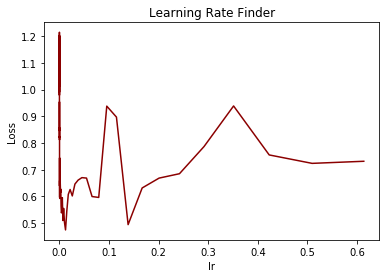

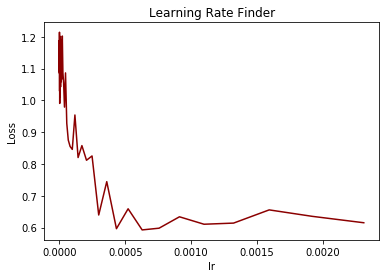

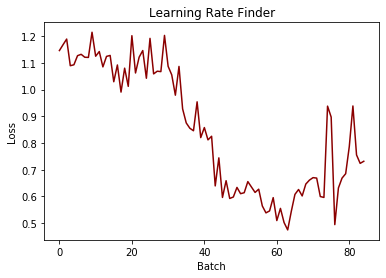

In [0]:
plot_lr(learning_rates, train_loss_epochs, "LossByLearningRate")
plot_lr(learning_rates[:55], train_loss_epochs[:55], "LossByLearningRate")
plot_lr(list(range(len(learning_rates))), train_loss_epochs, "LossByLearningRate", ("Batch", "Loss"))

In [0]:
!tar cvzf images.tar.gz *.png *.pdf *.eps

LossByBatch.png
LossByLearningRate.png
LossByLearningRateZoom.png
LossByBatch.pdf
LossByLearningRate.pdf
LossByLearningRateZoom.pdf
LossByBatch.eps
LossByLearningRate.eps
LossByLearningRateZoom.eps


In [0]:
files.download("images.tar.gz")

Batch 1: Train Loss: 1.1416029930114746   Train Acc: 0.5081068873405457
Batch 2: Train Loss: 0.7618598341941833   Train Acc: 0.6713712811470032
Batch 3: Train Loss: 0.7334505319595337   Train Acc: 0.6590242385864258
Batch 4: Train Loss: 0.6469032764434814   Train Acc: 0.6939276456832886
Batch 5: Train Loss: 0.5922139286994934   Train Acc: 0.7291350960731506
Batch 6: Train Loss: 0.5626916885375977   Train Acc: 0.7603802680969238
Batch 7: Train Loss: 0.5525528192520142   Train Acc: 0.7597648501396179
Batch 8: Train Loss: 0.49904683232307434   Train Acc: 0.7870835065841675
Batch 9: Train Loss: 0.5311968326568604   Train Acc: 0.7690555453300476
Batch 10: Train Loss: 0.5308589339256287   Train Acc: 0.7543266415596008
Batch 11: Train Loss: 0.5041908621788025   Train Acc: 0.7720451354980469
Batch 12: Train Loss: 0.45446157455444336   Train Acc: 0.8003761172294617
Batch 13: Train Loss: 0.4475818872451782   Train Acc: 0.8044994473457336
Batch 14: Train Loss: 0.49975597858428955   Train Acc: 0.7

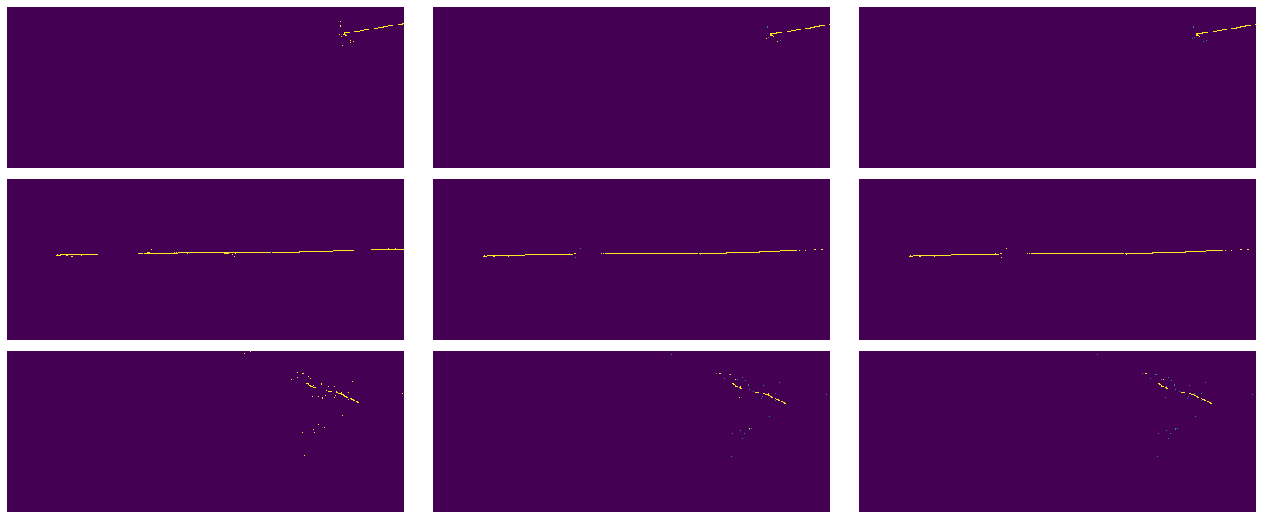

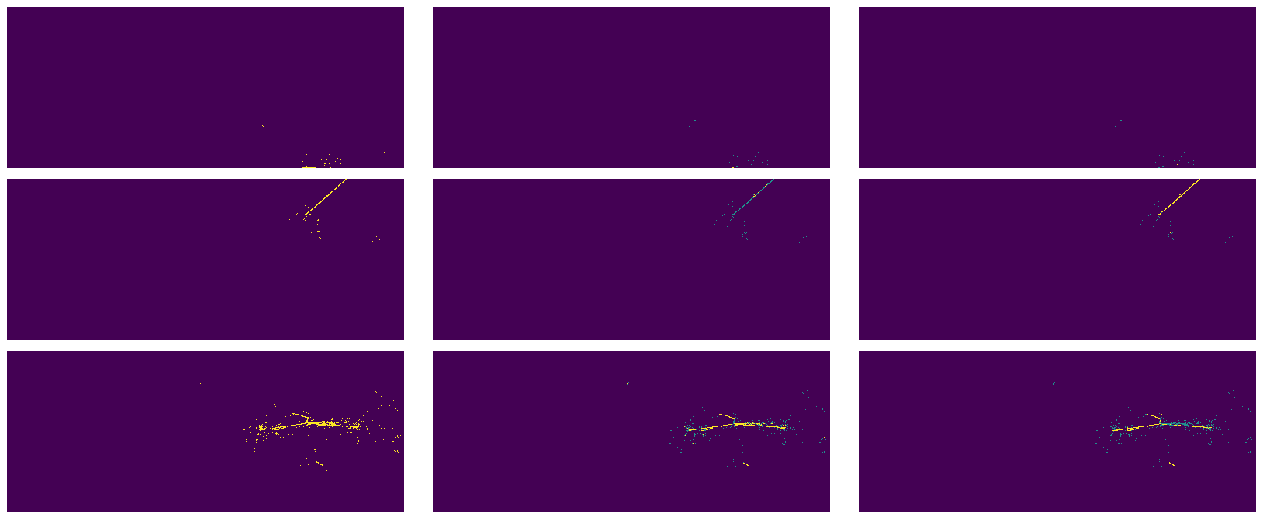

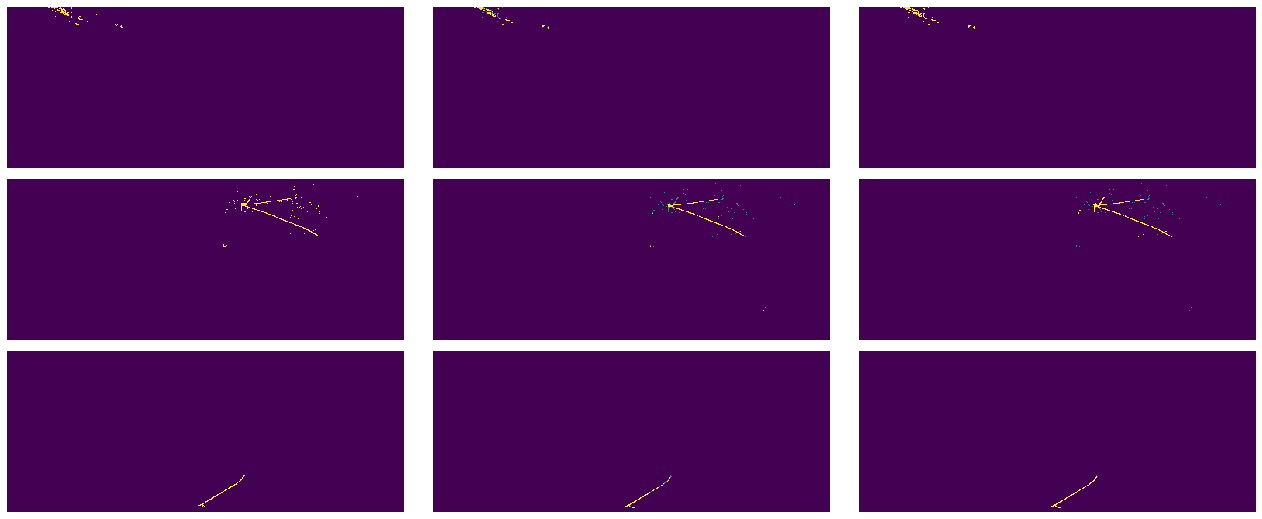

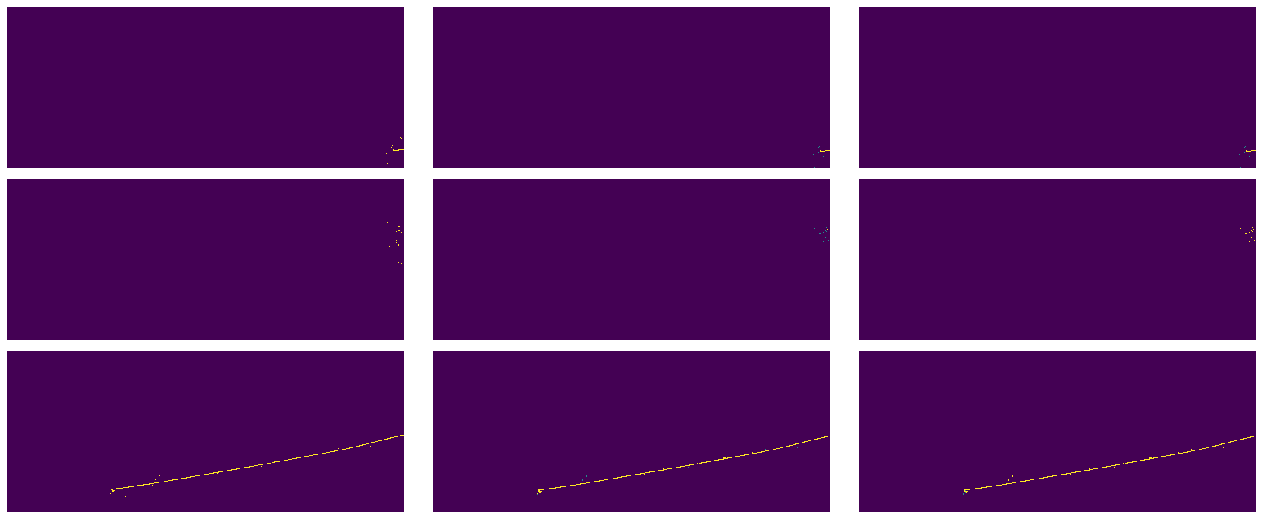

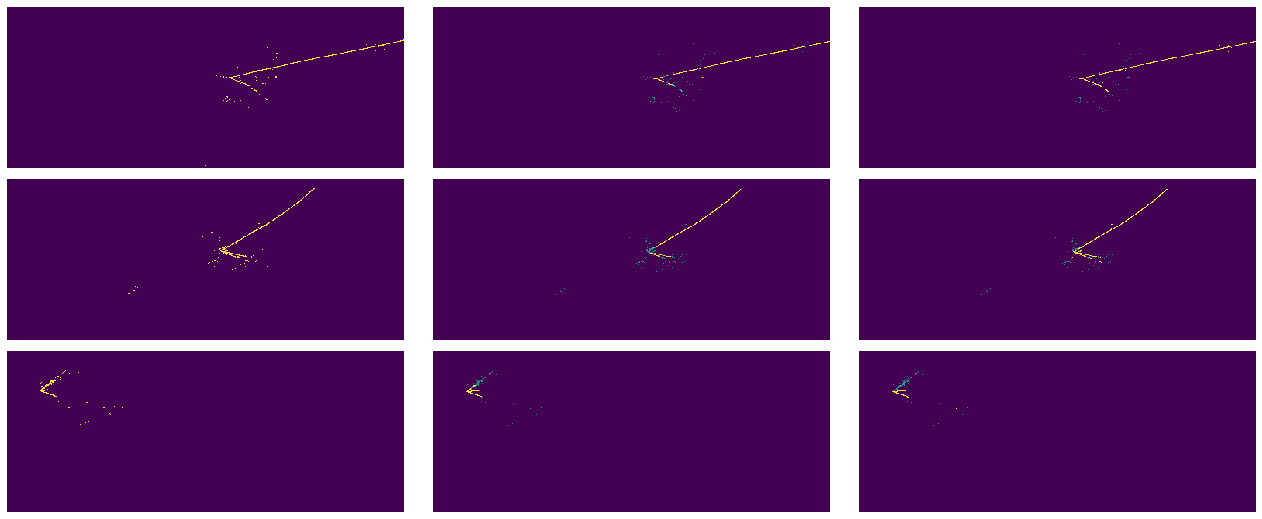

In [38]:
# Run
train_loss_epochs = []
train_acc_epochs = []
val_loss_epochs = []
val_acc_epochs = []
for epoch in list(range(5)):
    # Training
    model.train()
    optim.zero_grad()
    train_dl = bunch.train_dl
    losses = np.zeros(len(train_dl))
    accuracies = np.zeros(len(train_dl))
    for i, batch in enumerate(train_dl):
        images, masks = batch
        x = Variable(images)
        y = Variable(masks)
        pred = model.forward(x)

        loss = loss_fn(pred, y)
        losses[i] = loss.item()

        acc = accuracy(pred, y)
        accuracies[i] = acc

        if i == (len(train_dl) - 1):
            net_input = x.detach().numpy()
            net_pred = pred.detach().numpy()
            net_mask = y.detach().numpy()
            iu.show_batch(epoch, i, net_input, net_pred, net_mask, void_code)
        print("Batch {}: Train Loss: {}   Train Acc: {}".format(i + 1, losses[i], accuracies[i]))

        loss.backward()
        optim.step()
    train_loss_epochs.append(losses.mean())
    train_acc_epochs.append(accuracies.mean())
    # Validation
    model.eval()
    valid_dl = bunch.valid_dl
    val_losses = np.zeros(len(valid_dl))
    val_accuracies = np.zeros(len(valid_dl))
    with torch.no_grad():
        for i, batch in enumerate(valid_dl):
            images, masks = batch
            x = Variable(images)
            y = Variable(masks)
            pred = model.forward(x)
            loss = loss_fn(pred, y)
            val_losses[i] = loss.item()

            acc = accuracy(pred, y)
            val_accuracies[i] = acc
    val_loss_epochs.append(val_losses.mean())
    val_acc_epochs.append(val_accuracies.mean())
    print("Epoch {} : loss {} acc {}   val_loss {} val_acc {}:".format(
        epoch + 1, losses.mean(), accuracies.mean(),
        val_losses.mean(), val_accuracies.mean()))

In [13]:
!ls -l *.png

-rw-r--r-- 1 root root 5680 Nov 22 11:41 diagnostic_0_16.png
-rw-r--r-- 1 root root 7782 Nov 22 11:49 diagnostic_1_16.png
-rw-r--r-- 1 root root 6817 Nov 22 11:58 diagnostic_2_16.png
-rw-r--r-- 1 root root 5445 Nov 22 12:06 diagnostic_3_16.png
-rw-r--r-- 1 root root 7847 Nov 22 12:15 diagnostic_4_16.png


In [0]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [0]:
dump_tensors()

Total size: 0


/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: MODES has been renamed to Modes and will be removed in a future version of pywt.


In [0]:
#del x, y
#del images, masks
#del model
torch.cuda.empty_cache()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


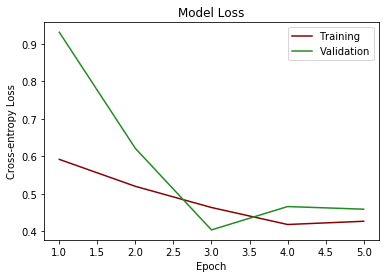

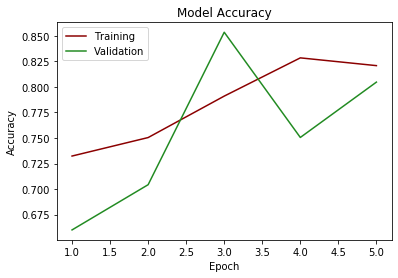

In [39]:
epoch_list = list(range(1, 6))
fig, ax = plt.subplots()
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy Loss')
ax.plot(epoch_list, train_loss_epochs, label='Training', c='darkred')
ax.plot(epoch_list, val_loss_epochs, label='Validation', c='forestgreen')
ax.legend(loc='upper right')
iu.save_figure(plt, "AverageLossVsTrainingEpoch")

fig, ax = plt.subplots()
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot(epoch_list, train_acc_epochs, label='Training', c='darkred')
ax.plot(epoch_list, val_acc_epochs, label='Validation', c='forestgreen')
ax.legend(loc='upper left')
iu.save_figure(plt, "AverageAccuracyVsTrainingEpoch")

In [40]:
!tar cvzf images.tar.gz *.png *.pdf *.eps
files.download("images.tar.gz")

AverageAccuracyVsTrainingEpoch.png
AverageLossVsTrainingEpoch.png
diagnostic_0_16.png
diagnostic_1_16.png
diagnostic_2_16.png
diagnostic_3_16.png
diagnostic_4_16.png
AverageAccuracyVsTrainingEpoch.pdf
AverageLossVsTrainingEpoch.pdf
diagnostic_0_16.pdf
diagnostic_1_16.pdf
diagnostic_2_16.pdf
diagnostic_3_16.pdf
diagnostic_4_16.pdf
AverageAccuracyVsTrainingEpoch.eps
AverageLossVsTrainingEpoch.eps
diagnostic_0_16.eps
diagnostic_1_16.eps
diagnostic_2_16.eps
diagnostic_3_16.eps
diagnostic_4_16.eps


In [0]:
!ls -l

total 1736
-rw-r--r-- 1 root   root    22490 Nov 14 13:22  AverageAccuracyVsTrainingEpoch.png
-rw-r--r-- 1 root   root    19800 Nov 14 13:22  AverageLossVsTrainingEpoch.png
-rw-r--r-- 1 root   root     3416 Nov 14 12:29 'data (1).py'
-rw-r--r-- 1 root   root     3416 Nov 14 12:12  data.py
drwxr-xr-x 4 197608 197121   4096 Nov 14 08:36  Images
drwxr-xr-x 2 root   root     4096 Nov 14 12:12  __pycache__
drwxr-xr-x 1 root   root     4096 Nov  6 16:17  sample_data
-rw-r--r-- 1 root   root   840513 Nov 14 12:29 'track_shower_images.tar (1).gz'
-rw-r--r-- 1 root   root   840513 Nov 14 12:12  track_shower_images.tar.gz
-rw-r--r-- 1 root   root     1264 Nov 14 12:29 'transforms (1).py'
-rw-r--r-- 1 root   root     1264 Nov 14 12:12  transforms.py
-rw-r--r-- 1 root   root     4289 Nov 14 12:29 'unet (1).py'
-rw-r--r-- 1 root   root     4289 Nov 14 12:12  unet.py
